In [135]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, log_loss
import scikitplot as skplt
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

%matplotlib inline

In [2]:
raw_data = pd.read_csv('../data/raw_data.csv')
df = raw_data[raw_data['y'].notnull()]

df_clean = pd.DataFrame(index=df.index)

# Clean date attribute
clean_date = df['watch-time-text'].str.extract(r"(\d+) de ([a-z]+)\. de (\d+)")
clean_date[0] = clean_date[0].dropna().astype(str)
clean_date[2] = clean_date[2].dropna().astype(str)

month_map = {"jan": "Jan",
             "fev": "Feb",
             "mar": "Mar",
             "abr": "Apr",
             "mai": "May",
             "jun": "Jun",
             "jul": "Jul",
             "ago": "Aug",
             "set": "Sep",
             "out": "Oct",
             "nov": "Nov",
             "dez": "Dec"}

clean_date[1] = clean_date[1].map(month_map)
clean_date = clean_date.dropna().apply(lambda x: " ".join(x), axis=1)

df_clean['date'] = pd.to_datetime(clean_date, format="%d %b %Y")

# Clean view number
views = df['watch-view-count'].str.extract(r"(\d+\.?\d*)", expand=False)
df_clean['views'] = views.str.replace(".", "").fillna(0).astype(int)

# Makaing features DataFrame
features = pd.DataFrame(index=df_clean.index)
y = df['y'].copy()

# Extracting time since publication feature
features['time_since_pub'] = (pd.to_datetime("2020-03-24") -  # HARDCODED
                              df_clean['date']) / np.timedelta64(1, 'D')

# Extracting n of view feature
features['views'] = df_clean['views']

# Extracting n of view/day feature
features['views_per_day'] = features['views'] / features['time_since_pub']

# Droping time_since_pub to prevent bias
features = features.drop(['time_since_pub'], axis=1)
features['date'] = df_clean['date']
features['index'] = features.index
features = features.set_index('date').sort_index().dropna()

y = pd.DataFrame(y)
y['date'] = df_clean['date']
y['index'] = y.index
y = y.set_index('date').sort_index()
y = y[y.index.notna()]

# Splitting the data set - 60% train 40% validation
n = len(features)
n_train = np.ceil(n * 0.6) - 1
n_val = n - n_train

X_train, X_val = (features.reset_index().loc[:n_train],
                  features.reset_index().loc[n_train+1:])
y_train, y_val = y.reset_index().loc[:n_train], y.reset_index().loc[n_train+1:]


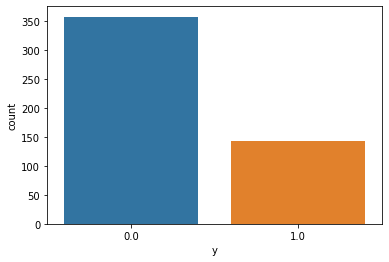

In [137]:
sns.countplot(df['y'])

In [4]:
X_train = X_train.set_index('index').drop('date', axis=1)
y_train = y_train.set_index('index').drop('date', axis=1)
X_val = X_val.set_index('index').drop('date', axis=1)
y_val = y_val.set_index('index').drop('date', axis=1)

In [5]:
df_clean['title'] = df['watch-title']

In [6]:
train_titles = df_clean.loc[X_train.index.tolist()]['title']
val_titles = df_clean.loc[X_val.index.tolist()]['title']

In [7]:
title_vec = TfidfVectorizer(min_df=2)
title_bow_train = title_vec.fit_transform(train_titles)
title_bow_val = title_vec.transform(val_titles)

In [8]:
X_train_title = hstack([X_train, title_bow_train])
X_val_title = hstack([X_val, title_bow_val])

In [9]:
mdl = RandomForestClassifier(n_estimators=1000, random_state=0, class_weight="balanced", n_jobs=6)
mdl.fit(X_train_title, y_train['y'])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=6, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [10]:
# Predicting on the validation set
val_proba = mdl.predict_proba(X_val_title)
preds = mdl.predict(X_val_title)

# Getting the metrics
print('log_loss: ', log_loss(y_val, preds))
print('avg_precision_score: ', average_precision_score(y_val, val_proba[:, 1]))
print('roc_auc: ', roc_auc_score(y_val, val_proba[:, 1]))

log_loss:  14.827260569506407
avg_precision_score:  0.5418522758941334
roc_auc:  0.6541735880398671


# ACTIVE LEARNING

In [111]:
df_u = raw_data[raw_data['y'].isnull()]

In [112]:
df_u = df_u[df_u['watch-title'].notnull()]
df_u.shape

(557, 18)

In [113]:
df_clean_u = pd.DataFrame(index=df_u.index)
df_clean_u['title'] = df_u['watch-title']

In [114]:
# Clean date attribute
clean_date = df_u['watch-time-text'].str.extract(r"(\d+) de ([a-z]+)\. de (\d+)")
clean_date[0] = clean_date[0].dropna().astype(str)
clean_date[1] = clean_date[1].map(month_map)
clean_date[2] = clean_date[2].dropna().astype(str)
clean_date = clean_date.dropna().apply(lambda x: " ".join(x), axis=1)

In [115]:
df_clean_u['date'] = pd.to_datetime(clean_date, format="%d %b %Y")
df_clean_u.dropna(inplace=True)
df_u = df_u.loc[df_clean_u.index]

In [118]:
# Clean view number
views = df_u['watch-view-count'].str.extract(r"(\d+\.?\d*)", expand=False)
df_clean_u['views'] = views.str.replace(".", "").fillna(0).astype(int)

In [119]:
# Making features DataFrame
features_u = pd.DataFrame(index=df_clean_u.index)

In [120]:
features_u['time_since_pub'] = (pd.to_datetime("2020-03-24") -  # HARDCODED
                                df_clean_u['date']) / np.timedelta64(1, 'D')

In [121]:
# Extracting n of view feature
features_u['views'] = df_clean_u['views']
# Extracting n of view/day feature
features_u['views_per_day'] = features_u['views'] / features_u['time_since_pub']

In [122]:
# Droping time_since_pub to prevent bias
features_u = features_u.drop(['time_since_pub'], axis=1)

In [123]:
# Features from title
title_bow_u = title_vec.transform(df_clean_u['title'])

In [124]:
X_title_u = hstack([features_u, title_bow_u])

In [125]:
proba_u = mdl.predict_proba(X_title_u)[:, 1]

In [126]:
df_u['p'] = proba_u

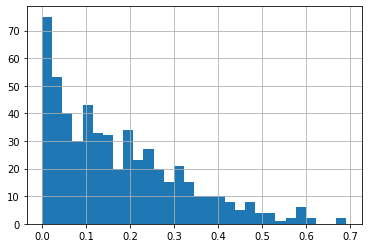

In [129]:
df_u['p'].hist(bins=30)

In [152]:
mask_u = (df_u['p'] >= 0.35) & (df_u['p'] <= 1.)
n_hard = mask_u.sum()
n_hard

71

In [153]:
hard_ones = df_u[mask_u]

In [154]:
n_random = 100 - n_hard
random_ones = df_u[~mask_u].sample(n_random, random_state=0)

In [155]:
random_ones.shape

(29, 19)

In [164]:
active_learning = pd.concat([hard_ones, random_ones])
active_learning.to_csv("../data/active_label.csv")

In [165]:
active_learning.shape

(100, 19)

In [166]:
hard_ones.shape

(71, 19)